In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
# ASSUME: Disaster occurs, and a given hh is affected
# QUESTION: how much does a hh lose when there is a disaster?

In [3]:
# Step 1
# --> Start with FIES 2015
df = pd.read_csv('training_data/temp_init.csv')[['region','province','income','social','pov_line','sub_line','ispoor']].head(1)
df['weight'] = 1.

df
# --> Assume savings rate = 0%: income = consumption

,region,province,income,social,pov_line,sub_line,ispoor,weight
0,ARMM,Maguindanao,243302.09,0.00338,22302.48,15573.95972,0,1.0


In [4]:
# Step 2
# What does the hh consumption tell us about its assets?

# --> Assume that every hh uses its assets to produce an income
# --> productivity of assets is equal to average productivity of capital in PHL
avg_prod_k = 0.337960802589002

# --> All income not from social transfers and remittances comes from capital 
df['capital'] = df['income']*(1-df['social'])/avg_prod_k
df

,region,province,income,social,pov_line,sub_line,ispoor,weight,capital
0,ARMM,Maguindanao,243302.09,0.00338,22302.48,15573.95972,0,1.0,717478.503651


In [5]:
# Step 3
# Some capital is privately owned by the household
# Some are publicly-owned assets (roads, utilities, etc) that the hh uses to generate income
# Some are owned by other hh (factories), but generate income for the hh from labor

# --> Get this fraction from DoF dataset (AIR catastrophe model)
public_assets = 0.1 # 10% of assets in the province
df['capital_prv'] = (1-public_assets)*df['capital']
df['capital_pub'] = public_assets*df['capital']
df[['capital','capital_prv','capital_pub']]

,capital,capital_prv,capital_pub
0,717478.503651,645730.653286,71747.850365


In [6]:
# Step 4
# When a hh is affected by a disaster, what fraction of its assets is destroyed?

# --> Load the vulnerability table
df_vul = pd.read_excel('training_data/vulnerability_curves_FIES.xlsx',sheetname='wall')[['desc','v']]
df_vul

,desc,v
0,Not Applicable,0.7
1,Salvaged/makeshift materials,0.7
2,Mixed but predominantly salvaged materials,0.7
3,"Light material (cogon,nipa,anahaw)",0.4
4,Mixed but predominantly light materials,0.4
5,"Strong material(galvanized,iron,al,tile,concre...",0.1
6,Mixed but predominantly strong materials,0.1


In [7]:
# Step 5
# --> These categorical descriptors are is included in FIES for each hh...
# --> This is a weathly hh, so we'll assume it's built from strong materials:
df['v'] = 0.1

# --> Include a randon smearing factor to incorporate uncertainty (20%) without changing mean losses
df['v'] *= np.random.uniform(0.8,1.2)

df

,region,province,income,social,pov_line,sub_line,ispoor,weight,capital,capital_prv,capital_pub,v
0,ARMM,Maguindanao,243302.09,0.00338,22302.48,15573.95972,0,1.0,717478.503651,645730.653286,71747.850365,0.0949


In [8]:
# Step 6
# Put it together: if a disaster happens and this hh is affected, how much does it lose?
# We assume here that all assets used by hh have same vulnerability as hh private assets
df['d_cap'] = df[['capital','v']].prod(axis=1)
df['d_cap_prv'] = df[['capital_prv','v']].prod(axis=1)
df['d_cap_pub'] = df[['capital_pub','v']].prod(axis=1)


df[['d_cap','d_cap_prv','d_cap_pub']]

,d_cap,d_cap_prv,d_cap_pub
0,68088.62867,61279.765803,6808.862867


In [9]:
# Step 7
# Using the above equation, calculate income loss:
# --> Income from social systems & remittances 'social' is not vulnerable

df['d_inc'] = df['d_cap']*avg_prod_k/(1-df['social'])
df[['capital','income','d_cap','d_inc']]

,capital,income,d_cap,d_inc
0,717478.503651,243302.09,68088.62867,23089.340763


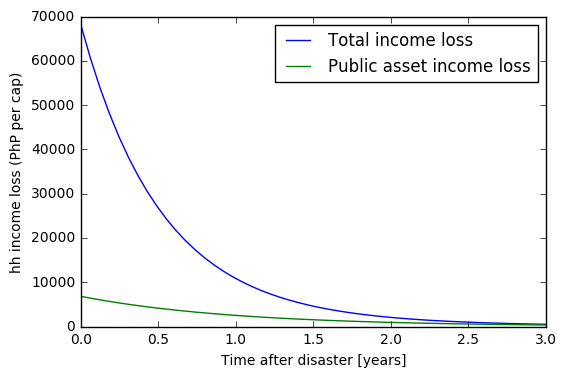

In [12]:
# Step 8
# Now we have assets & income before AND after disaster
# What does reconstruction look like?

# Now assume that assets (public and private) are rebuilt exponentially over some years (T_prv, T_pub) after disaster
# --> Definition: after T years, 95% of initial asset losses are rebuilt
# --> R_prv = ln(1/0.05)/T_prv
# --> R_pub = ln(1/0.05)/T_pub

# --> T_pub (government overseen & financed) can differ from T_prv (based on hh finances after disaster)

# Let's say:
# --> T_prv = 1.5 years
R_prv = np.log(1/0.05)/1.5
# NOTE: in the model, this parameter is calculated from hh finances

# --> T_pub = 3 years
R_pub = np.log(1/0.05)/3.0
# NOTE: T_pub = 3 yrs for all provinces in the model

# d_inc(t) = d_cap_prv*e^(-t*R_prv) + d_cap_pub*e^(-t*R_pub)
d_inc_prv, d_inc_pub = [],[]

T_max = 3
n_steps = 50

t_reco = np.linspace(0,T_max,num=n_steps,endpoint=True)

for _t in t_reco:
    d_inc_prv.append(float(df['d_cap_prv'])*math.e**(-_t*R_prv))
    d_inc_pub.append(float(df['d_cap_pub'])*math.e**(-_t*R_pub))
    
d_inc_sum = np.array(d_inc_prv)+np.array(d_inc_pub)

plt.cla()
ax = plt.plot(t_reco,d_inc_sum,label='Total income loss')
plt.plot(t_reco,d_inc_pub,label='Public asset income loss')
plt.legend()
plt.xlabel('Time after disaster [years]')
plt.ylabel('hh income loss (PhP per cap)')
plt.xlim(0,3)
plt.show()

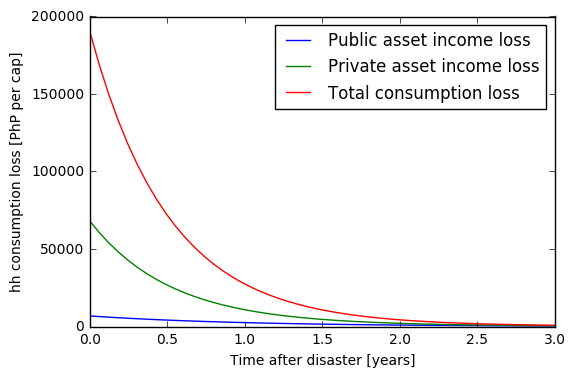

In [13]:
# Step 9
# So now we have modeled the hh's recovery from the disaster
# But the capital doesn't rebuild itself; the hh has to start saving in order to rebuild its private capital
# That means that consumption no longer equals income
# --> All hh in the country pay a fee to rebuild personal assets (proportional to hh capital)
reco_fee = []
for _t in t_reco:
    reco_fee.append(float(df['d_cap_prv'])*R_prv*math.e**(-_t*R_prv))
  
# NOTE: integral over reco_fee from 0 to infinity = d_cap_prv (initial private asset losses)

d_cons_sum = np.array(d_inc_prv)+np.array(d_inc_pub)+np.array(reco_fee)
    
plt.cla()
ax = plt.plot(t_reco,d_inc_pub,label='Public asset income loss')
plt.plot(t_reco,d_inc_sum,label='Private asset income loss')
plt.plot(t_reco,d_cons_sum,label='Total consumption loss')
plt.legend()
plt.xlabel('Time after disaster [years]')
plt.ylabel('hh consumption loss [PhP per cap]')
plt.show()

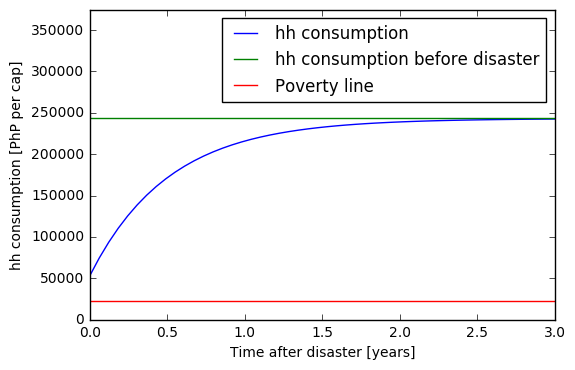

In [14]:
# Step 10
# Look at how hh consumption recovers over time

plt.cla()
plt.plot(t_reco,float(df['income'])-d_cons_sum,label='hh consumption')
plt.plot([t_reco[0],t_reco[-1]],[float(df['income']),float(df['income'])],label='hh consumption before disaster')
plt.plot([t_reco[0],t_reco[-1]],[float(df['pov_line']),float(df['pov_line'])],label='Poverty line')
plt.legend()
plt.ylim(0,375000)
plt.xlabel('Time after disaster [years]')
plt.ylabel('hh consumption [PhP per cap]')
plt.show()

Cumulative well-being loss:  0.00138899609297
Asset loss: 68088.62866990233
Well-being loss: 18741.7442701
Resilience: 3.63299315628


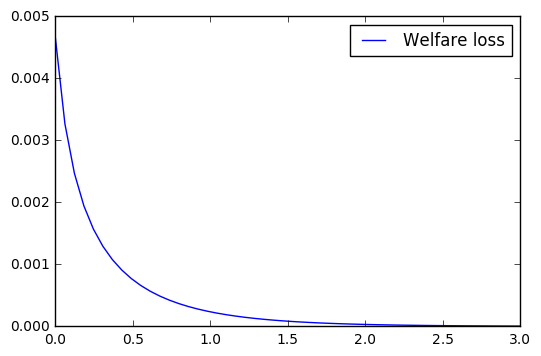

In [15]:
# Step 12
# Look at well-being losses during recovery
inc_elast = 1.5
discount = 0.06
avg_gdp_pc = 56676.887075693
wprime = avg_gdp_pc**(-inc_elast)
dt = T_max/n_steps

welf_init = []
welf_loss,welf_loss_curr = [],[]
welf_loss_cum = 0
for n_t, _t in enumerate(t_reco):
    
    _wl = math.e**(-_t*discount)/(1.-inc_elast)*(float(df['income'])**(1.-inc_elast)
                                                - (float(df['income'])-d_cons_sum[n_t])**(1.-inc_elast))
    
    welf_loss.append(_wl)
    welf_loss_curr.append(_wl/wprime)
    welf_loss_cum += _wl*dt 

print('Cumulative well-being loss: ',welf_loss_cum)
print('Asset loss:',float(df['d_cap']))
print('Well-being loss:',welf_loss_cum/wprime)
print('Resilience:',float(df['d_cap'])/(welf_loss_cum/wprime))
plt.cla()
plt.plot(t_reco,welf_loss,label='Welfare loss')
plt.legend()
plt.show()

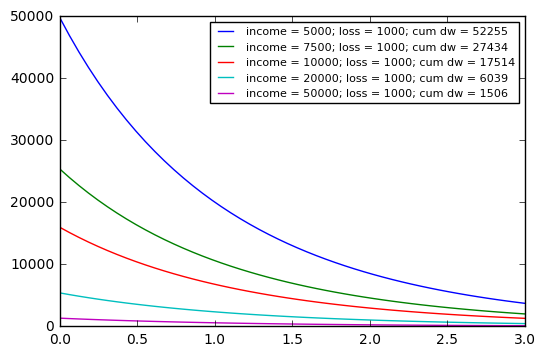

In [16]:
# Step 13
# Let's look at the well-being loss for multiple hh facing the same loss:
hh_income = [5000,7500,10000,20000,50000]
d_capital = 1000
T =4
R = np.log(1/0.05)/T

for _hhinc in hh_income:
    hh_dw = []
    hh_dw_tot = 0
    
    for _t in t_reco:
    
        _dc = d_capital*(avg_prod_k+R)*math.e**(-_t*R)
        assert(_hhinc-_dc > 0)
        # ^ Have to make sure consumtpion doesn't go negative...would represent death(?)
        
        _dw = math.e**(-_t*discount)/(1-inc_elast)*(_hhinc**(1-inc_elast)-(_hhinc-_dc)**(1-inc_elast))
        
        hh_dw.append(_dw/wprime)
        
        hh_dw_tot += dt*_dw/wprime
        
    plt.plot(t_reco,hh_dw,label='income = '+str(_hhinc)+'; loss = '+str(d_capital)+'; cum dw = '+str(int(hh_dw_tot)))
    #plt.semilogy(t_reco,hh_dw,label='income = '+str(_hhinc))
    
plt.legend(fontsize=8)
plt.show()